### Napari unwarper - grid of points

In [1]:
import napari
from tifffile import imread
import numpy as np

from pointpats import PointPattern
import matplotlib.pyplot as plt

/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [2]:
def generate_perfect_grid(data, 
                          rows,
                          cols,
                          start_margin=.1
                         ):
    '''
    Generates a 2D grid of dots 
    
    Parameters
    ----------
    data : np.array : image
    rows : int : number of rows
    cols : int : number of cols
    start_margin : float : Relative margin at start and end 
    
    Returns
    -------
    grid_dots : np.aray: rows x cols
    
    '''   
    HEIGHT = data.shape[1]
    WIDTH  = data.shape[0]

    HEIGHT_start = HEIGHT * start_margin
    HEIGHT_end   = HEIGHT - (HEIGHT * start_margin)
    WIDTH_start  = WIDTH * start_margin
    WIDTH_end    = WIDTH - (WIDTH * start_margin)
    
    row_pos = np.linspace(HEIGHT_start, HEIGHT_end, num=rows)
    col_pos = np.linspace(WIDTH_start, WIDTH_end,   num=cols)
    
    grid_dots = []
    for y in row_pos:
        for x in col_pos: 
            grid_dots.append([y,x])
    grid_dots = np.vstack(grid_dots)    
    
    return grid_dots

In [3]:
original_tif_file = '/Volumes/marinaj/PerformanceTests/Ragnhild_Horst_room 2.309_M009/FOV/M009/FOV/0um/AVG_M009_FOV_50um_7mW_00001.tif'
original_tif = imread(original_tif_file)
print(original_tif.shape)

(512, 512)


In [4]:
# Try to read multi page tif (timeseries) -> to auto detect and create avg. int. projection 
#original_tif = '/Volumes/moser/marinaj/PerformanceTests/Ragnhild_Horst_room 2.309/FOV/M009/FOV/M009_50umgrid_0um_00001.tif'
#original_tif = imread(original_tif)

In [5]:
print(f'Dimensions of tif: {original_tif.shape}')
if len(original_tif.shape) == 3:
    print(f'Timeseries assumed')
    assert original_tif.shape[1] == original_tif.shape[2], 'Dimensions not supported'
    original_tif = np.mean(original_tif, axis=0)
    print('Created average projection')

Dimensions of tif: (512, 512)


In [6]:
viewer = napari.view_image(original_tif, rgb=False, name='Grid image')
grid_image_layer = viewer.layers['Grid image']

Adding dots ... 
 rows: 9 x cols: 9 | margin: 0.1
Unwarping ...
margin now at 0.1000
margin now at 0.1050
margin now at 0.1100


In [7]:
rows = 9
cols = 9
start_margin = .1

Adding dots ... 
 rows: 9 x cols: 9 | margin: 0.1
Unwarping ...
margin now at 0.1000


In [8]:
grid_dots = generate_perfect_grid(viewer.layers['Grid image'].data,
                                  rows=rows,
                                  cols=cols,
                                  start_margin=start_margin,
                                 )

In [9]:
viewer.add_points(name='Perfect grid',
                  data=grid_dots,
                  edge_width=1, 
                  edge_color='#000000',  
                  face_color = 'white',
                  opacity = .8,    
                  size=3,
                  blending='translucent'
              )

<Points layer 'Perfect grid' at 0x7f8e1deebbb0>

In [10]:
#viewer.layers['Perfect grid'].visible = False

Adding dots ... 
 rows: 9 x cols: 9 | margin: 0.1
Adding dots ... 
 rows: 9 x cols: 9 | margin: 0.1
Deleting layer


In [16]:
viewer.add_points(data=grid_dots.copy(),
                  name='Grid', 
                  edge_width=.4, 
                  edge_color='orangered',  
                  face_color = 'white',
                  opacity = .5,    
                  size=8,
                  blending='translucent'
              )
viewer.layers['Grid'].mode ='select'
viewer.layers['Grid'].symbol ='x'

In [17]:
def unwarp(usr_dots, grid_dots, grid_image_original):
    unwarped = warp_images(
                from_points   = usr_dots,
                to_points     = grid_dots,
                images        = [grid_image_original],
                output_region = [0, 0, grid_image_original.shape[1], grid_image_original.shape[0]],
                interpolation_order = 5,
                approximate_grid = 1,
                )[0]
    # Check whether margins are free
    col1 = (unwarped[0,:] == 0).all()
    col2 = (unwarped[-1,:] == 0).all()
    row1 = (unwarped[:,0] == 0).all()
    row2 = (unwarped[:,-1] == 0).all()

    status = col1 == col2 == row1 == row2 == True
    return unwarped, status

### Retrieve user dots

In [18]:
import sys
sys.path.append('/Users/hotte/Documents/python/dj-moser-imaging/helpers/')
from mini2p_unwarp import *

In [19]:
layer_grid = viewer.layers['Grid']
usr_dots = layer_grid.data

In [20]:
grid_dots = generate_perfect_grid(viewer.layers['Grid image'].data,
                                  rows=rows,
                                  cols=cols,
                                  start_margin=start_margin
                                  )

In [28]:
grid_image_original = grid_image_layer.data
unwarped, status = unwarp(usr_dots, grid_dots, grid_image_original)

margin_ = start_margin 

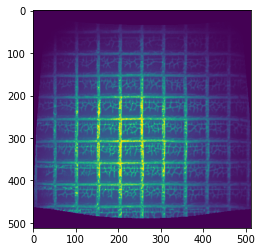

In [29]:
plt.imshow(unwarped)

In [30]:
status

False

In [31]:
if status == True:
    while status: 
        print(f'margin now at {margin:.4f}')
        margin_-=0.005
        grid_dots_ = generate_perfect_grid(data = grid_image_original,
                                           rows = rows,
                                           cols = cols,
                                           start_margin = margin_,
                                           )
        unwarped, status = unwarp(usr_dots, grid_dots_, grid_image_original)
else:
    while not status: 
        print(f'margin now at {margin_:.4f}')
        margin_+=0.005
        grid_dots_ = generate_perfect_grid(data = grid_image_original,
                                           rows = rows,
                                           cols = cols,
                                           start_margin = margin_,
                                           )
        unwarped, status = unwarp(usr_dots, grid_dots_, grid_image_original)

margin now at 0.1000
margin now at 0.1050
margin now at 0.1100


In [32]:
#unwarped[:,0] = np.max(unwarped)
#unwarped[:,-1] = np.max(unwarped)
#unwarped[0,:] = np.max(unwarped)
#unwarped[-1,:] = np.max(unwarped)

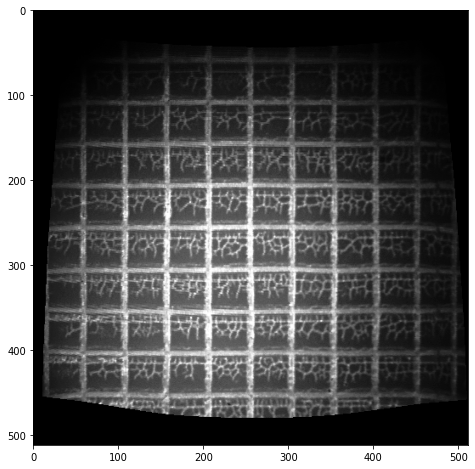

In [33]:
#grid_image_original = viewer.layers['Grid image'].data
#grid_image_unwarped = warp(grid_image_original.T, tform, order=4)

figure = plt.figure(figsize=(8,8))
ax = figure.add_subplot(111)
ax.imshow(unwarped, cmap='Greys_r')
#ax.plot(tform.inverse(grid_dots)[:, 0], tform.inverse(grid_dots)[:, 1], '.w')

plt.show()

In [34]:
viewer.add_image(data=unwarped, rgb=False, name='Unwarped grid image')

<Image layer 'Unwarped grid image [1]' at 0x7fa9ed35cc70>

napari has 1 layers


In [124]:
unwarped.shape

(256, 256)